# **1. Importing Important Libraries**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# **2. Data Exploration**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/household_power_consumption.zip -d /content/data/

Archive:  /content/drive/MyDrive/household_power_consumption.zip
  inflating: /content/data/household_power_consumption.txt  


In [4]:
df = pd.read_csv(
    '/content/data/household_power_consumption.txt',
    sep=';',
    low_memory=False
)

In [5]:
df.shape

(2075259, 9)

In [6]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [7]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [8]:
df.dtypes

,0
Date,object
Time,object
Global_active_power,object
Global_reactive_power,object
Voltage,object
Global_intensity,object
Sub_metering_1,object
Sub_metering_2,object
Sub_metering_3,float64


In [9]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


In [10]:
df.describe(include='O')

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2
count,2075259,2075259,2075259,2075259,2075259,2075259,2075259,2075259
unique,1442,1440,4187,533,2838,222,89,82
top,25/11/2010,19:43:00,?,0.000,?,1.000,0.000,0.000
freq,1440,1442,25979,481561,25979,172785,1880175,1436830


# **3. Data Cleaning**

***Converts specified columns to numeric type and replaces invalid values with NaN***

In [11]:
numeric_cols = ["Global_active_power","Global_reactive_power","Voltage",
                "Global_intensity","Sub_metering_1","Sub_metering_2","Sub_metering_3"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


***Checking Duplicated***

In [14]:
df.duplicated().sum()

np.int64(0)

***Datetime Indexing and Handling Missing Values With Time Interpolation***

In [15]:
df.isnull().sum().sum()

np.int64(181853)

In [16]:
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [17]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df[numeric_cols] = df[numeric_cols].interpolate(method='time')

In [18]:
df.isnull().sum().sum()

np.int64(0)

In [19]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


# **Feature Engineering**

***Daily, Monthly and Hourly Resampling***

In [21]:
daily_consumption = df.resample('D').sum()
monthly_consumption = df.resample('M').sum()

/tmp/ipython-input-1579241356.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_consumption = df.resample('M').sum()


In [22]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [23]:
daily_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [24]:
monthly_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-31,41826.806,2890.228,5.310732e+06,176651.8,27535.0,48759.0,162986.0
2007-01-31,69017.296,5922.929,1.075399e+07,292264.4,56433.0,79274.5,329610.5
2007-02-28,56496.828,4581.798,9.697733e+06,238497.0,47584.0,64640.0,270308.0
2007-03-31,58862.721,5122.412,1.073652e+07,248774.5,60769.0,104762.0,290361.0
2007-04-30,36529.192,5221.383,1.032721e+07,156983.0,42078.0,38417.0,189503.0


In [25]:
hourly_consumption = df.resample('H').sum()
hourly_consumption.head()

/tmp/ipython-input-2551976823.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_consumption = df.resample('H').sum()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


***Daily Average Sub-Metering***

In [26]:
daily_consumption['Avg_Sub1'] = daily_consumption['Sub_metering_1'] / 24
daily_consumption['Avg_Sub2'] = daily_consumption['Sub_metering_2'] / 24
daily_consumption['Avg_Sub3'] = daily_consumption['Sub_metering_3'] / 24
daily_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Avg_Sub1,Avg_Sub2,Avg_Sub3
Datetime,,,,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,0.000000,22.750000,205.250000
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,84.708333,174.458333,555.875000
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,44.291667,109.208333,584.083333
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,34.958333,316.750000,258.208333
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,0.000000,110.333333,585.958333


***Monthly Average Sub-Metering***

In [27]:
daily_counts_per_month = daily_consumption.resample('M').count()['Global_active_power']

monthly_consumption['Total_active_power'] = monthly_consumption['Global_active_power']
monthly_consumption['Avg_Sub1'] = monthly_consumption['Sub_metering_1'] / daily_counts_per_month
monthly_consumption['Avg_Sub2'] = monthly_consumption['Sub_metering_2'] / daily_counts_per_month
monthly_consumption['Avg_Sub3'] = monthly_consumption['Sub_metering_3'] / daily_counts_per_month
monthly_consumption.head()

/tmp/ipython-input-3456306966.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts_per_month = daily_consumption.resample('M').count()['Global_active_power']


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_active_power,Avg_Sub1,Avg_Sub2,Avg_Sub3
Datetime,,,,,,,,,,,
2006-12-31,41826.806,2890.228,5.310732e+06,176651.8,27535.0,48759.0,162986.0,41826.806,1720.937500,3047.437500,10186.625000
2007-01-31,69017.296,5922.929,1.075399e+07,292264.4,56433.0,79274.5,329610.5,69017.296,1820.419355,2557.241935,10632.596774
2007-02-28,56496.828,4581.798,9.697733e+06,238497.0,47584.0,64640.0,270308.0,56496.828,1699.428571,2308.571429,9653.857143
2007-03-31,58862.721,5122.412,1.073652e+07,248774.5,60769.0,104762.0,290361.0,58862.721,1960.290323,3379.419355,9366.483871
2007-04-30,36529.192,5221.383,1.032721e+07,156983.0,42078.0,38417.0,189503.0,36529.192,1402.600000,1280.566667,6316.766667


# **4. Data Preprocessing**

In [28]:
scaler = StandardScaler()
features_to_scale = ["Total_active_power","Avg_Sub1","Avg_Sub2","Avg_Sub3"]
monthly_scaled = monthly_consumption.copy()
monthly_scaled[features_to_scale] = scaler.fit_transform(monthly_scaled[features_to_scale])
monthly_scaled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Total_active_power,Avg_Sub1,Avg_Sub2,Avg_Sub3
Datetime,,,,,,,,,,,
2006-12-31,41826.806,2890.228,5.310732e+06,176651.8,27535.0,48759.0,162986.0,-0.447657,0.246156,2.134474,0.399705
2007-01-31,69017.296,5922.929,1.075399e+07,292264.4,56433.0,79274.5,329610.5,1.844214,0.448908,1.248274,0.600095
2007-02-28,56496.828,4581.798,9.697733e+06,238497.0,47584.0,64640.0,270308.0,0.788871,0.202319,0.798714,0.160315
2007-03-31,58862.721,5122.412,1.073652e+07,248774.5,60769.0,104762.0,290361.0,0.988290,0.733977,2.734648,0.031189
2007-04-30,36529.192,5221.383,1.032721e+07,156983.0,42078.0,38417.0,189503.0,-0.894190,-0.402643,-1.059765,-1.339150


***Feature Selection & Target Creation for Monthly Forecasting***

In [32]:
monthly_consumption['Total_active_power_next'] = monthly_consumption['Total_active_power'].shift(-1)
monthly_consumption = monthly_consumption[:-1]  #Cause Last Month does not have a Target

X = monthly_consumption[["Avg_Sub1","Avg_Sub2","Avg_Sub3","Total_active_power"]].values
y = monthly_consumption["Total_active_power_next"].values

***Temporal and Seasonal Patterns for Electricity Forecasting***

In [34]:
def add_features(df):
    df_feat = df.copy()

    df_feat['month'] = df_feat.index.month
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['year'] = df_feat.index.year


    df_feat['is_month_end'] = (df_feat.index.is_month_end).astype(int)


    df_feat['total_sub_ratio'] = df_feat['Total_active_power'] / (df_feat['Avg_Sub1'] + df_feat['Avg_Sub2'] + df_feat['Avg_Sub3'] + 1e-10)
    df_feat['sub1_to_total'] = df_feat['Avg_Sub1'] / df_feat['Total_active_power']
    df_feat['sub2_to_total'] = df_feat['Avg_Sub2'] / df_feat['Total_active_power']
    df_feat['sub3_to_total'] = df_feat['Avg_Sub3'] / df_feat['Total_active_power']


    for lag in [1, 2, 3, 12]:
        df_feat[f'total_lag_{lag}'] = df_feat['Total_active_power'].shift(lag)

        for sub in ['Avg_Sub1', 'Avg_Sub2', 'Avg_Sub3']:
            df_feat[f'{sub}_lag_{lag}'] = df_feat[sub].shift(lag)



    for window in [3, 6, 12]:
        df_feat[f'total_ma_{window}'] = df_feat['Total_active_power'].rolling(window=window).mean().shift(1)


    df_feat['sin_month'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['cos_month'] = np.cos(2 * np.pi * df_feat['month'] / 12)

    return df_feat

In [37]:
monthly_consumption_featured = add_features(monthly_consumption)
monthly_consumption_featured = monthly_consumption_featured.dropna() #Lags may lead to NAN.

monthly_consumption_featured.shape

(34, 41)

***Preparing Target and Splitting Time Series Data***

In [40]:
monthly_consumption_featured['target'] = monthly_consumption_featured['Total_active_power'].shift(-1)
df_final = monthly_consumption_featured.dropna()

features = [col for col in df_final.columns if col not in ['target']]
X = df_final[features]
y = df_final['target']


train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(len(X_train))
print(len(X_test))

26
7


In [41]:
best_model = None
best_score = float('inf')
results = {}

models_to_try = {
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=42
    )
}

In [42]:
for name, model in models_to_try.items():
    print(name)

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    results[name] = {
        'MAE_train': mae_train,
        'MAE_test': mae_test,
        'RMSE_test': rmse_test,
        'R2_test': r2_test,
        'model': model
    }

    print(f"  MAE : {mae_train:.2f}")
    print(f"  MAE : {mae_test:.2f}")
    print(f"  RMSE : {rmse_test:.2f}")
    print(f"  R² : {r2_test:.3f}")

    if mae_test < best_score:
        best_score = mae_test
        best_model = model
        best_model_name = name

RandomForest
  MAE : 1685.46
  MAE : 1600.27
  RMSE : 1963.05
  R² : 0.934
GradientBoosting
  MAE : 20.30
  MAE : 1455.88
  RMSE : 1666.09
  R² : 0.952


In [43]:
print("Best Model: ", best_model_name)
print(f"Least MAE: {best_score:.2f}")

y_pred_best = best_model.predict(X_test)

mean_actual = y_test.mean()
mae_percentage = (best_score / mean_actual) * 100

print(f"Mean Actual Consumption: {mean_actual:.2f}")
print(f"MAE% : {mae_percentage:.1f}%")

Best Model:  GradientBoosting
Least MAE: 1455.88
Mean Actual Consumption: 41098.58
MAE% : 3.5%


In [44]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

print("\n Most Important Features: ")
print(feature_importance)


 Most Important Features: 
                    feature  importance
11  Total_active_power_next    0.804230
40                cos_month    0.062464
32             total_lag_12    0.020228
38              total_ma_12    0.015664
28              total_lag_3    0.011753
22           Avg_Sub2_lag_1    0.010733
33          Avg_Sub1_lag_12    0.010201
29           Avg_Sub1_lag_3    0.006779
19            sub3_to_total    0.006542
27           Avg_Sub3_lag_2    0.005219
9                  Avg_Sub2    0.004840
17            sub1_to_total    0.003868
16          total_sub_ratio    0.003801
12                    month    0.003579
7        Total_active_power    0.003140


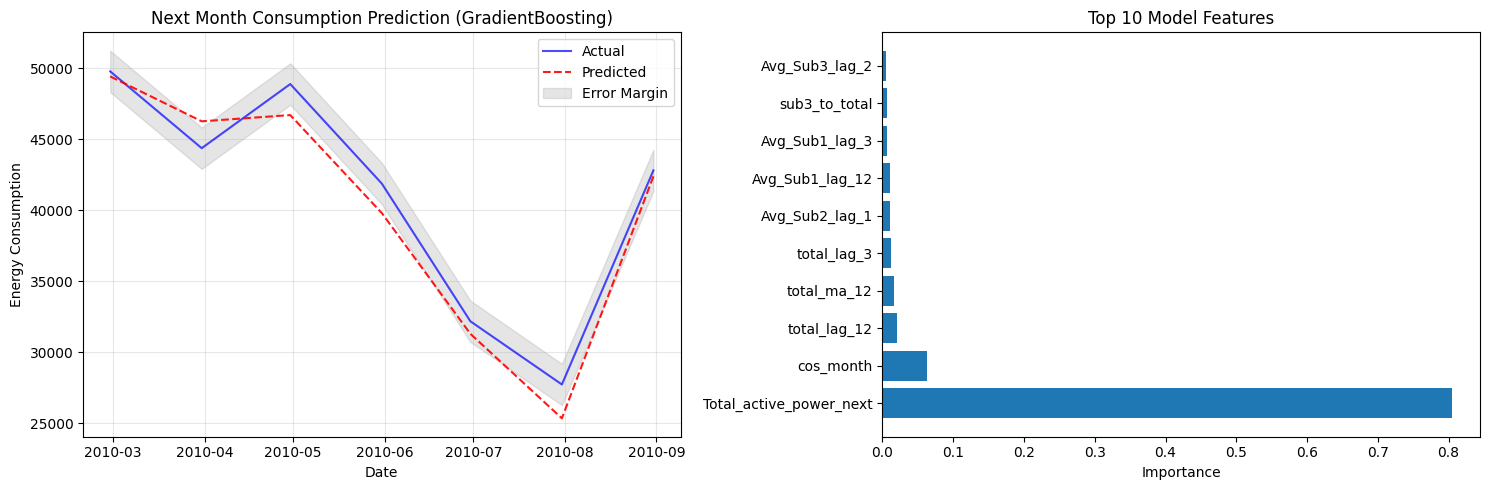

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

plt.plot(y_test.index, y_test.values, 'b-', label='Actual', alpha=0.7)

plt.plot(y_test.index, y_pred_best, 'r--', label='Predicted', alpha=0.9)

plt.fill_between(
    y_test.index,
    y_test.values - best_score,
    y_test.values + best_score,
    alpha=0.2, color='gray', label='Error Margin'
)

plt.title(f'Next Month Consumption Prediction ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

top_features = feature_importance.head(10)

plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 10 Model Features')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()


In [46]:
def predict_next_month(current_data):

    current_df = pd.DataFrame([current_data])

    current_df_featured = add_features(current_df)

    prediction = best_model.predict(current_df_featured[features])[0]

    return prediction

In [47]:
import joblib
joblib.dump(best_model, "energy_model.pkl")
joblib.dump(features, "model_features.pkl")


['model_features.pkl']

In [48]:
monthly_consumption_featured.to_csv("monthly_consumption_clean.csv", index=True)